#  Deep Learning
# Lab 12: IMDB Movies Reviews Sentiment Classification using LSTMS



## Objectives


1.	How to put together the building blocks used in LSTMS.
2.	Have a good undertanding on how sequences -- any data that has some temporal semantics (e.g., time series, natural language, images etc.) -- fit into and benefit from a recurrent architecture.




## 1. IMDb Review Classification:  LSTMS



In [1]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
# from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.utils import pad_sequences
# from keras.preprocessing.sequence import pad_sequences
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Activation
# from keras.layers.embeddings import Embedding
import numpy as np
# fix random seed for reproducibility
numpy.random.seed(1)

In [2]:
from keras.models import Sequential
from keras.layers import Embedding

In [3]:
# We want to have a finite vocabulary to make sure that our word matrices are not arbitrarily small
vocabulary_size = 10000

# We also want to have a finite length of reviews and not have to process really long sentences.
max_review_length = 500

Computers have no built-in knowledge of words or their meanings and cannot understand them in any rich way that humans do -- hence, the purpose of Natural Language Processing (NLP). As with any data science, computer science, machine learning task, the first crucial step is to clean (pre-process) your data so that you can soundly make use of it. Within NLP, this first step is called Tokenization and it concerns how to represent each token (a.k.a. word) of your corpus (i.e., dataset).

#### TOKENIZATION

A ``token`` refers to a single, atomic unit of meaning (i.e., a word). How should our computers represent each word? We could read in our corpus word by word and store each word as a String (data structure). However, Strings tend to use more computer memory than Integers and can become cumbersome. As long as we preserve the uniqueness of the tokens and are consistent, we are better off converting each distinct word to a distinct number (Integer). This is standard practice within NLP / computer science / data science, etc.
As a simple example of tokenization, we can see a small example.

If the five sentences below were our entire corpus, our conversion would look as follows:

1. i have books - [1, 4, 7]
2. interesting books are useful [10,2,9,8]
3. i have computers [1,4,6]
4. computers are interesting and useful [6,9,11,10,8]
5. books and computers are both valuable. [2,10,2,9,13,12]
6. Bye Bye [7,7]

Create tokens for vocabulary based on frequency of occurrence. Hence, we assign the following tokens

I-1, books-2, computers-3, have-4, are-5, computers-6,bye-7, useful-8, are-9, and-10,interesting-11, valuable-12, both-13

Thankfully, our dataset is already represented in such a tokenized form.

**NOTE:** Often times, depending on your NLP task, it is useful to also perform other pre-processing, cleaning steps, such as:
- treating each punctuation mark as a token (e.g., , . ! ? are each separate tokens)
- lower-casing all words (so that a given word isn't treated differently just because it starts a sentence or not)
- separating each sentence with a unique symbol (e.g., <S> and </S>)
- removing words that are incredibly common (e.g., function words, (in)definite articles). These are referred to as 'stopwords'). For language modelling, we DO NOT remove stopwords. A sentence's meaning needs to include all of the original words.

#### Load data

In [4]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocabulary_size)
print('Number of reviews', len(X_train))
print('Length of first and fifth review before padding', len(X_train[0]) ,len(X_train[4]))
print('First review', X_train[0])
print('First label', y_train[0])

17464789/17464789 [==============================] - 0s 0us/step
Number of reviews 25000
Length of first and fifth review before padding 218 147
First review [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104,

#### Preprocess data

If we were training our RNN one sentence at a time, it would be okay to have sentences of varying lengths. However, as with any neural network, it can be sometimes be advantageous to train inputs in batches. When doing so with RNNs, our input tensors need to be of the same length/dimensions. Thus, let's pad our sentences.

In [5]:
X_train = pad_sequences(X_train, maxlen=max_review_length)
X_test = pad_sequences(X_test, maxlen=max_review_length)
print('Length of first and fifth review after padding', len(X_train[0]) ,len(X_train[4]))

Length of first and fifth review after padding 500 500




###  EMBEDDINGS

#### What is an embedding layer ? 

An embedding is a "distributed representation" (e.g., vector) of a particular atomic item (e.g., word token, object, etc). When representing items by embeddings:
- each distinct item should be represented by its own unique embedding
- the semantic similarity between items should correspond to the similarity between their respective embeddings (i.e., words that are more similar to one another should have embeddings that are more similar to each other).

There are essentially an infinite number of ways to create such embeddings, and since these representations have such a great influence on the performance of our models, there has been an incredible amount of research dedicated to this very aspect. If you are interested in learning more, start with the astromonically impactful papers of [word2vec](https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf) and [GloVe](https://www.aclweb.org/anthology/D14-1162.pdf).

In general, though, one can view the embedding process as a linear projection from one vector space to another (e.g., a vector space of unique words being mapped to a world of fixed-length, dense vectors filled with continuous-valued numbers. For NLP, we usually use embeddings to project the one-hot encodings of words (i.e., a vector that is the length of the entire vocabulary, and it is filled with all zeros except for a single value of 1 that corresponds to the particular word) on to a lower-dimensional continuous space (e.g., vectors of size 100) so that the input surface is dense and possibly smooth. Thus, one can view this embedding layer process as just a transformation from $\mathbb{R}^{inp}$ to $\mathbb{R}^{emb}$

In [6]:
embedding_dim = 100

### MODEL : Simple RNN

Two great blogs that are helpful for understanding the workings of a RNN and LSTM are

1. http://karpathy.github.io/2015/05/21/rnn-effectiveness/
2. http://colah.github.io/posts/2015-08-Understanding-LSTMs/

At a high-level, an RNN is similar to a feed-forward neural network (FFNN) in that there is an input layer, a hidden layer, and an output layer. The input layer is fully connected to the hidden layer, and the hidden layer is fully connected to the output layer. However, the crux of what makes it a **recurrent** neural network is that the hidden layer for a given time _t_ is not only based on the input layer at time _t_ but also the hidden layer from time _t-1_.

Mathematically, a simpleRNN can be defined by the following recurrence relation.

<center>$h_t = \sigma(W([h_{t-1},x_{t}])+b)$
    


In [7]:
# % write ccode for your RNN model training
lstm = Sequential()

lstm.add(Embedding(vocabulary_size,32,input_length =len(X_train[0]))) # num_words=15000
lstm.add(LSTM(16, input_shape=(vocabulary_size,max_review_length)))
lstm.add(Dense(1)) #flatten
lstm.add(Activation("sigmoid")) #using sigmoid for binary classification

print(lstm.summary())
lstm.compile(loss="binary_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 32)           320000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 323,153
Trainable params: 323,153
Non-trainable params: 0
_________________________________________________________________
None


#### EXERCISE

 * Try changing the hyperparams, use other RNNs, more layers, check if increasing the number of epochs is useful.

 * Try reversing the data from validation set and check if commutative property of addition is learned by the model.

In [8]:
history = lstm.fit(X_train,y_train,validation_data = (X_test,y_test),epochs = 10,batch_size=128,verbose = 1)

Epoch 1/10
196/196 [==============================] - 66s 325ms/step - loss: 0.5492 - accuracy: 0.7621 - val_loss: 0.4334 - val_accuracy: 0.8330
Epoch 2/10
196/196 [==============================] - 64s 326ms/step - loss: 0.3537 - accuracy: 0.8659 - val_loss: 0.3364 - val_accuracy: 0.8646
Epoch 3/10
196/196 [==============================] - 62s 318ms/step - loss: 0.2695 - accuracy: 0.9010 - val_loss: 0.3126 - val_accuracy: 0.8728
Epoch 4/10
196/196 [==============================] - 61s 312ms/step - loss: 0.2251 - accuracy: 0.9174 - val_loss: 0.3178 - val_accuracy: 0.8661
Epoch 5/10
196/196 [==============================] - 66s 338ms/step - loss: 0.1934 - accuracy: 0.9305 - val_loss: 0.5681 - val_accuracy: 0.7742
Epoch 6/10
196/196 [==============================] - 61s 312ms/step - loss: 0.1758 - accuracy: 0.9384 - val_loss: 0.3301 - val_accuracy: 0.8742
Epoch 7/10
196/196 [==============================] - 60s 306ms/step - loss: 0.1576 - accuracy: 0.9447 - val_loss: 0.3286 - val_ac

In [9]:
score = lstm.evaluate(X_test,y_test)

782/782 [==============================] - 27s 35ms/step - loss: 0.3865 - accuracy: 0.8666


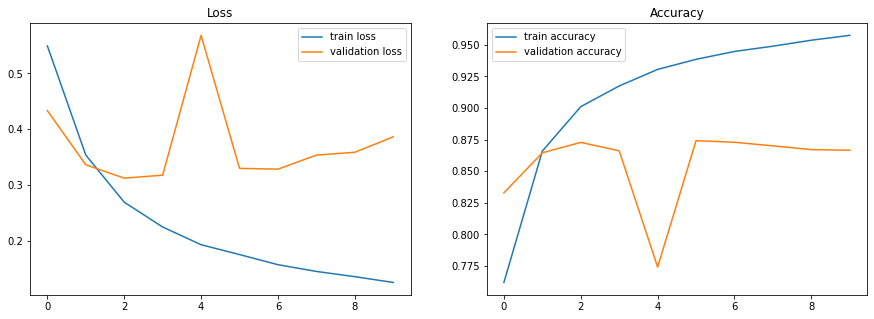

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history.history['loss'], label='train loss')
ax[0].plot(history.history['val_loss'], label='validation loss')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(history.history['accuracy'], label='train accuracy')
ax[1].plot(history.history['val_accuracy'], label='validation accuracy')
ax[1].set_title('Accuracy')
ax[1].legend()